In [23]:
import os
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import csv
import cv2
import numpy as np
from tensorflow.keras.layers import Input, Dense, ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
import random
import tensorflow.keras.utils as conv_utils
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.metrics import auc, confusion_matrix
import seaborn as sns
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ["CUDA_VISIBLE_DEVICES"]='1'
tf.random.set_seed(0)

# 1. Load data and preprocess

In [2]:
data_path = '/shared/hdds_20T/ms1233/pyspace/ThyroidED/dataset/'

normal_imgs = []
mild_imgs = []
severe_imgs = []

normal_path = data_path+'Case1_Normal/ROI/'
for img in os.listdir(normal_path):
    if img.lower().endswith('png'):
        normal_imgs.append(cv2.imread(os.path.join(normal_path,img))[:,:,0])

        
mild_path = data_path+'Case2_TED_without_Optic_Neuropathy/ROI/'
for img in os.listdir(mild_path):
    if img.lower().endswith('png'):
        mild_imgs.append(cv2.imread(os.path.join(mild_path,img))[:,:,0])
        
severe_path = data_path+'Case3_TED_with_Optic_Neuropathy/ROI/'
for img in os.listdir(severe_path):
    if img.lower().endswith('png'):
        severe_imgs.append(cv2.imread(os.path.join(severe_path,img))[:,:,0])

## data distribution

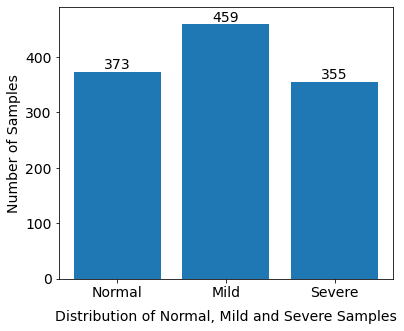

In [3]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+5, y[i], fontsize=14, ha = 'center')

fig, ax = plt.subplots(figsize=(6, 5))
plt.xlabel('Distribution of Normal, Mild and Severe Samples', fontsize=14, labelpad=10)
plt.ylabel('Number of Samples', fontsize=14)
plt.bar(['Normal', 'Mild', 'Severe'], [373, 459, 355])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(0,490)
addlabels(['Normal', 'Mild', 'Severe'], [373, 459, 355])

In [4]:
## visualize data sample

In [5]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0,'black'), (0.06,'blue'), 
                                                                  (0.23, '#2ab6c6'), (0.38,'yellow'), 
                                                               (0.6,'red'), (1,'white')])
def isgray(img):
    if len(img.shape) < 3: return True
    if img.shape[2]  == 1: return True
    b,g,r = img[:,:,0], img[:,:,1], img[:,:,2]
    if (b==g).all() and (b==r).all(): return True
    return False

def resize(imgs, size=(256,256)):
    imgs_scaled = []
    for img in imgs:
        imgs_scaled.append(cv2.resize(img, size))
    return imgs_scaled

def visualize(imgs, cols=3, sizes=(9,9), axis_on=True, cm=cmap):
    fig = plt.figure(figsize=sizes, constrained_layout=True)
    for i, img in enumerate(imgs):
        plt_idx = i+1
        plt.subplot(1, cols, plt_idx)
        plt.grid(False)
        ax = plt.gca()
        ax.set_title(str(img.shape[0])+'x'+str(img.shape[1]))
        if not axis_on:
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
        im = ax.imshow(img, cmap=cm)
    plt.show()

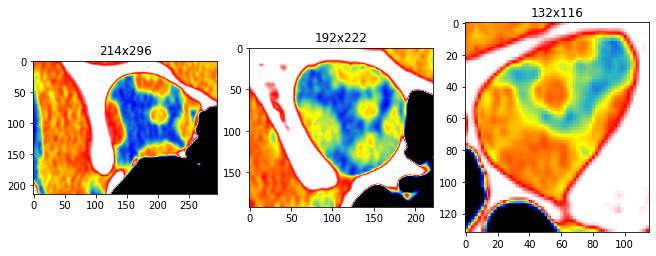

In [6]:
visualize(imgs=[normal_imgs[2], mild_imgs[2], severe_imgs[2]])

## resize the image

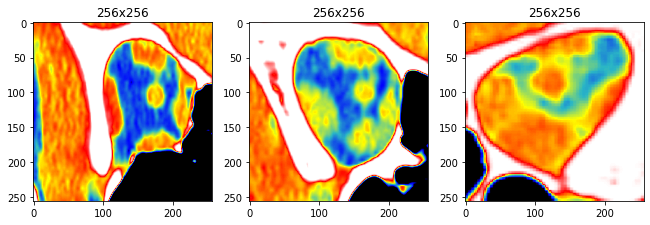

In [7]:
normal_imgs_resize = resize(normal_imgs)
mild_imgs_resize = resize(mild_imgs)
severe_imgs_resize = resize(severe_imgs)

visualize(imgs=[normal_imgs_resize[2], mild_imgs_resize[2], severe_imgs_resize[2]])

In [24]:
normal_3dimgs.shape

(373, 256, 256, 3)

# 2. Prepare train and test data

In [8]:
from sklearn.model_selection import train_test_split

def to_3dimg(imgs, cm=None):
    imgs3d = []
    for img in imgs:
        img = cm((img/255.))
        colored_image = (img[:, :, :3])
        imgs3d.append(colored_image)
    return np.array(imgs3d)

normal_3dimgs = to_3dimg(normal_imgs_resize, cm=cmap)
mild_3dimgs = to_3dimg(mild_imgs_resize, cm=cmap)
severe_3dimgs = to_3dimg(severe_imgs_resize, cm=cmap)

# combine samples and create prediction labels for all samples (case1=0, case2=1, case3=2)
samples = np.concatenate([normal_3dimgs, mild_3dimgs, severe_3dimgs], axis=0)
labels = np.array([0]*len(normal_3dimgs) + [1]*len(mild_3dimgs) + [2]*len(severe_3dimgs))

unique, counts = np.unique(labels, return_counts=True)
print('train sample size:', len(samples), ' samples distribution: ', dict(zip(unique, counts)), '\n')

labels = conv_utils.to_categorical(labels)

# Shuffle the data for stable model training
permutation = np.random.permutation(len(samples))
samples = samples[permutation]
labels = labels[permutation]

# split the data
train_x, test_x, train_y, test_y = train_test_split(samples, labels, test_size=0.2, random_state=42)

print('train size:{}, test size:{}\n'.format(len(train_x), len(test_x)))

train sample size: 1187  samples distribution:  {0: 373, 1: 459, 2: 355} 

train size:949, test size:238



## Data loader

In [9]:
batch_size = 8

class DataGenerator(ImageDataGenerator):
    def flow(self, x, y, batch_size, *args, **kwargs):
        generator = super().flow(x, y, batch_size=batch_size, *args, **kwargs)
        while True:
            ori = next(generator) 
            yield ori[0], ori[1]
            
train_datagen = DataGenerator()
train_generator = train_datagen.flow(
    train_x, 
    train_y,
    batch_size=batch_size,
    seed=42)

val_datagen = DataGenerator()
val_generator = val_datagen.flow(
    test_x, 
    test_y,
    batch_size=batch_size,
    seed=10)

# 3. Train the VGG model

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf

base_model = VGG16(input_shape = (256, 256, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')

# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.2)(x)
# Add a final sigmoid layer with 1 node for classification output
x = Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.00001), 
              loss = 'categorical_crossentropy', metrics = ['acc',                                                 
                                                            tf.keras.metrics.AUC()])

model.fit(train_generator, validation_data = val_generator, 
                    steps_per_epoch = int(len(train_y)/batch_size), 
                    epochs = 100,
                    validation_steps=int(len(test_y)/batch_size),
                    verbose=2)

Epoch 1/100
118/118 - 7s - loss: 0.7055 - acc: 0.6908 - auc_1: 0.8619 - val_loss: 1.0019 - val_acc: 0.5690 - val_auc_1: 0.8135
Epoch 2/100
118/118 - 6s - loss: 0.3567 - acc: 0.8591 - auc_1: 0.9651 - val_loss: 0.3910 - val_acc: 0.8103 - val_auc_1: 0.9550
Epoch 3/100
118/118 - 6s - loss: 0.1816 - acc: 0.9320 - auc_1: 0.9911 - val_loss: 0.3817 - val_acc: 0.8276 - val_auc_1: 0.9593
Epoch 4/100
118/118 - 6s - loss: 0.0818 - acc: 0.9724 - auc_1: 0.9985 - val_loss: 0.3933 - val_acc: 0.8276 - val_auc_1: 0.9631
Epoch 5/100
118/118 - 6s - loss: 0.0413 - acc: 0.9819 - auc_1: 0.9995 - val_loss: 0.3724 - val_acc: 0.8664 - val_auc_1: 0.9699
Epoch 6/100
118/118 - 6s - loss: 0.0265 - acc: 0.9915 - auc_1: 0.9998 - val_loss: 0.4362 - val_acc: 0.8621 - val_auc_1: 0.9656
Epoch 7/100
118/118 - 6s - loss: 0.0118 - acc: 0.9968 - auc_1: 0.9999 - val_loss: 0.4548 - val_acc: 0.8448 - val_auc_1: 0.9626
Epoch 8/100
118/118 - 6s - loss: 0.0046 - acc: 1.0000 - auc_1: 1.0000 - val_loss: 0.4322 - val_acc: 0.8707 - va

Epoch 64/100
118/118 - 6s - loss: 1.2326e-07 - acc: 1.0000 - auc_1: 1.0000 - val_loss: 1.1944 - val_acc: 0.8879 - val_auc_1: 0.9377
Epoch 65/100
118/118 - 6s - loss: 1.9636e-08 - acc: 1.0000 - auc_1: 1.0000 - val_loss: 1.1037 - val_acc: 0.8966 - val_auc_1: 0.9470
Epoch 66/100
118/118 - 6s - loss: 1.6469e-08 - acc: 1.0000 - auc_1: 1.0000 - val_loss: 1.0290 - val_acc: 0.8879 - val_auc_1: 0.9520
Epoch 67/100
118/118 - 6s - loss: 5.0673e-10 - acc: 1.0000 - auc_1: 1.0000 - val_loss: 0.9414 - val_acc: 0.8966 - val_auc_1: 0.9500
Epoch 68/100
118/118 - 6s - loss: 0.0000e+00 - acc: 1.0000 - auc_1: 1.0000 - val_loss: 0.9673 - val_acc: 0.8966 - val_auc_1: 0.9471
Epoch 69/100
118/118 - 6s - loss: 8.4878e-09 - acc: 1.0000 - auc_1: 1.0000 - val_loss: 0.9879 - val_acc: 0.9009 - val_auc_1: 0.9465
Epoch 70/100
118/118 - 6s - loss: 0.0000e+00 - acc: 1.0000 - auc_1: 1.0000 - val_loss: 0.9972 - val_acc: 0.8966 - val_auc_1: 0.9463
Epoch 71/100
118/118 - 6s - loss: 1.7878e-06 - acc: 1.0000 - auc_1: 1.0000 -

In [22]:
# save pretrained model
# model.save("vgg_ted_model.h5")

# 4. Evaluate on the test data

0.8865546218487395

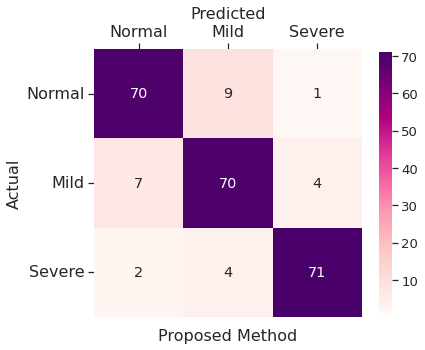

In [14]:
pred_y = model.predict(test_x)

true = test_y.argmax(axis=1)
pred = pred_y.argmax(axis=1)

matrix = confusion_matrix(true, pred)

acc = accuracy_score(true, pred)
cfmat = confusion_matrix(true, pred)


fig1 = plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)
y = ['Normal', 'Mild', 'Severe']
ax = sns.heatmap(cfmat, annot=True, square=True, xticklabels=y, 
                 yticklabels=y, cmap='RdPu', fmt="d", cbar_kws={"shrink": 0.8})
ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.set_xticklabels(y, fontsize=16)
ax.set_yticklabels(y, fontsize=16)
plt.title("Predicted", fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xlabel('Proposed Method', fontsize=16, labelpad=11)

plt.yticks(rotation=0) 
plt.xticks(rotation=0) 

accuracy = cfmat.diagonal().sum() / cfmat.sum()
accuracy

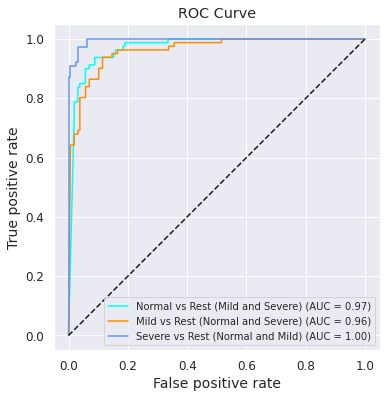

In [19]:
n_classes = 3
target_names = ['Normal vs Rest (Mild and Severe)', 'Mild vs Rest (Normal and Severe)', 'Severe vs Rest (Normal and Mild)']

fig2, ax = plt.subplots(figsize=(6, 6))

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        test_y[:, class_id],
        pred_y[:, class_id],
        name=f"{target_names[class_id]}",
        color=color,
        ax=ax)
    
plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title("ROC Curve")
plt.legend(loc='best', fontsize=10)